In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# from osgeo import gdal
import seaborn as sns
import rasterio
from pyproj import Proj, transform
from rasterio.transform import from_origin
import ephem
import datetime
import math
import warnings

### Assign paths of drone data, slope and aspect

In [2]:
file_path = r"C:\Users\JANUSHI SHASTRI\Desktop\CIRES_PROJECT\Drone Data\drive-download-20230711T205208Z-001\niwot_6_23_2022_ortho_cropped.tif"
slope_path= r"C:\Users\JANUSHI SHASTRI\Desktop\CIRES_PROJECT\Drone Data\slope_new.tif"
aspect_path = r"C:\Users\JANUSHI SHASTRI\Desktop\CIRES_PROJECT\Drone Data\aspect_new.tif"

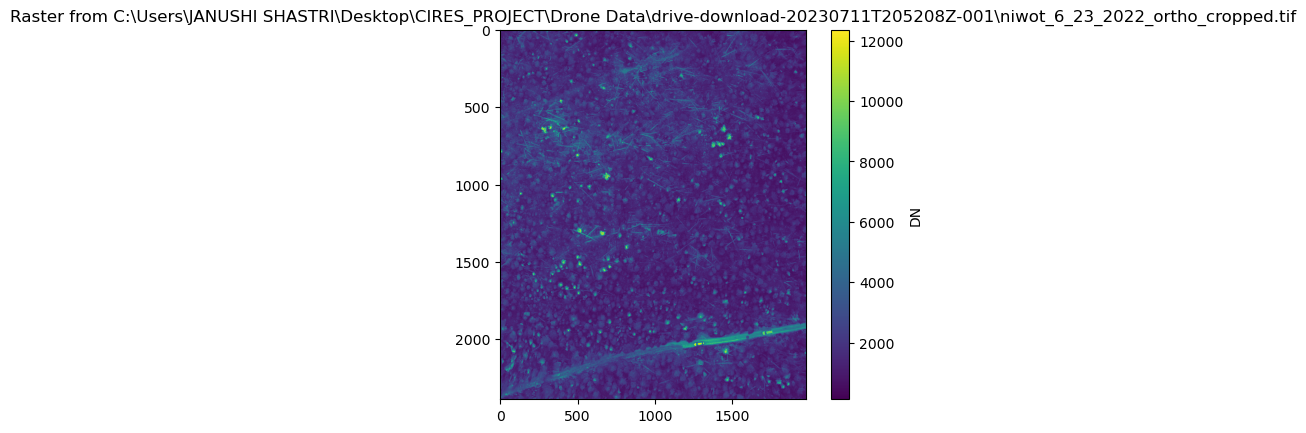

c:\Users\JANUSHI SHASTRI\anaconda3\envs\cires-demo\lib\site-packages\rasterio\__init__.py:319: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


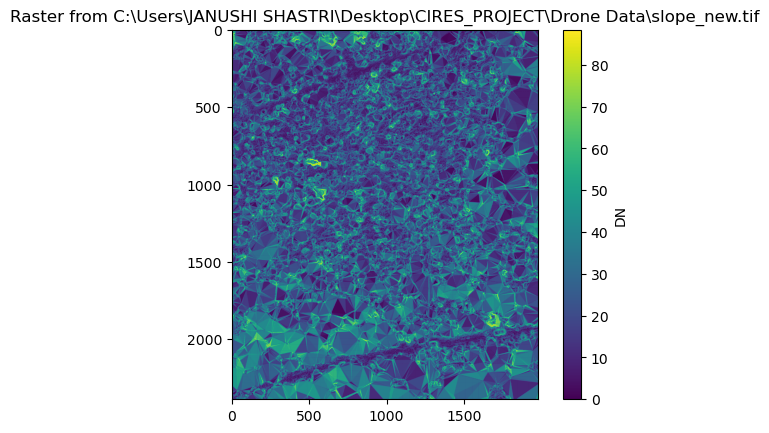

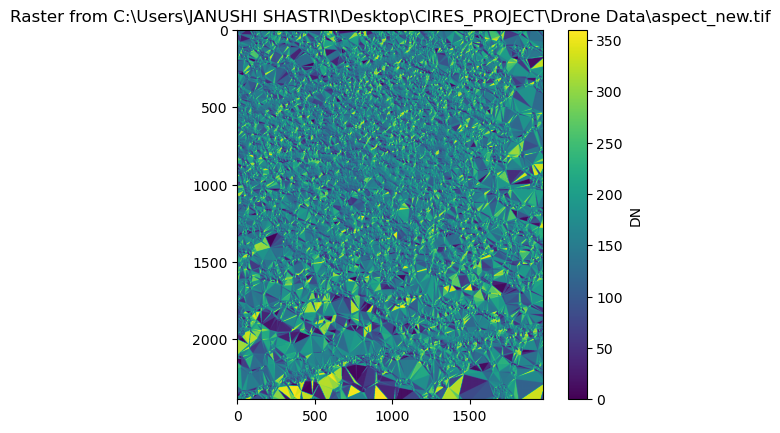

In [3]:
# List of files
file_paths = [file_path, slope_path, aspect_path]

for file in file_paths:
    # Open the GeoTIFF file
    with rasterio.open(file) as src:
        # Read the raster data
        raster = src.read(1)

    # Plot the raster data
    plt.imshow(raster, cmap='viridis')
    plt.colorbar(label='DN')
    plt.title(f"Raster from {file}")
    plt.show()

### Parameters for SCS+C topo corr

#### This reads only one band

In [4]:
with rasterio.open(file_path) as src:
    raster_ortho = src.read(1)
    print(raster_ortho)
    print(raster_ortho.shape)
    print(src.meta)

[[ 941. 1290. 1653. ... 1292. 1678. 1475.]
 [1106. 1091.  889. ... 1784. 1406. 1308.]
 [1170. 1179.  951. ... 1452. 1592. 1204.]
 ...
 [2045. 1585. 1279. ...  946.  909.  684.]
 [1599. 1519. 2244. ...  611.  904.  815.]
 [1994. 2016. 1910. ...  525.  652.  858.]]
(2388, 1977)
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.3999999521443642e+38, 'width': 1977, 'height': 2388, 'count': 11, 'crs': CRS.from_wkt('PROJCS["NAD83 / UTM zone 13N",GEOGCS["NAD83",DATUM["North American Datum 1983",SPHEROID["GRS 1980",6378137,298.257222101004]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-105],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(0.07107889999999543, 0.0, 452382.82172944996,
       0.0, -0.07107

#### This reads all bands from drone data

In [5]:
with rasterio.open(file_path) as src:
    raster = src.read()  # This reads all bands

print(raster.shape)  
# print(metadata)

(11, 2388, 1977)


### Function to get slope and aspect using rasterio

In [6]:
def read_and_print_raster(file_path):
    with rasterio.open(file_path) as src:
        raster_data = src.read(1)
        print(raster_data)
        print(raster_data.shape)

    return raster_data



In [7]:
slope = read_and_print_raster(slope_path)


[[30.621765  46.55295   40.93316   ...  4.742068   4.581489   2.5465121]
 [54.896538  61.788727  61.764896  ...  8.605572   8.646949   6.215332 ]
 [54.868443  61.77376   61.77376   ...  8.947673   8.947673   6.3375406]
 ...
 [12.373323  17.516346  18.32045   ... 58.638344  58.645355  38.575043 ]
 [ 6.348709   7.5600686 11.83701   ... 58.641247  58.641247  40.073593 ]
 [ 8.194622   5.6624017 14.166594  ... 50.940727  50.934956  31.152447 ]]
(2388, 1977)


In [8]:
aspect = read_and_print_raster(aspect_path)

[[  6.4136243  16.223854   19.672905  ... 140.4602    141.96347
  173.90414  ]
 [ 16.137783   12.179552   12.164875  ... 152.27174   153.14558
  162.56512  ]
 [ 15.992949   12.200817   12.200817  ... 153.43495   153.43495
  161.9853   ]
 ...
 [170.53767   160.28326   151.07529   ...  86.93993    86.925766
   85.15183  ]
 [ 61.160145   62.025642   91.40863   ...  86.82017    86.82017
   85.345634 ]
 [ 52.754284   73.13441    68.23479   ...  85.683975   85.843254
  102.970215 ]]
(2388, 1977)


### Calcualting sun angles

In [9]:
def get_coordinates(file_path):
    # Load geotiff
    with rasterio.open(file_path) as r:
        T0 = r.transform  # upper-left pixel corner affine transform
        p1 = Proj(r.crs)
        A = r.read()  # pixel values

    # All rows and columns
    cols, rows = np.meshgrid(np.arange(A.shape[2]), np.arange(A.shape[1]))

    # Get pixel coordinates from the rows and columns
    T1 = T0 * rasterio.Affine.scale(1, -1)
    rc2en = lambda r, c: (c, r) * T1  
    eastings, northings = np.vectorize(rc2en, otypes=[float, float])(rows, cols)

    p2 = Proj(proj='latlong', datum='WGS84')
    longs, lats = transform(p1, p2, eastings, northings)

    return longs, lats

file_path = r'C:\Users\JANUSHI SHASTRI\Desktop\CIRES_PROJECT\Drone Data\drive-download-20230711T205208Z-001\niwot_6_23_2022_ortho_cropped.tif'
longitudes, latitudes = get_coordinates(file_path)

# Calculate the central latitude and longitude
center_long = np.mean(longitudes)
center_lat = np.mean(latitudes)

# Convert the date and time to UTC. The time given is 2:34 PM, which is 14:34 in 24-hour format
date_time_str = '2022-06-23 14:34:00'

# Calculation of sun azimuth and zenith angle
# Ephemeris computations
observer = ephem.Observer()
observer.lat = str(center_lat)
observer.lon = str(center_long)
observer.date = ephem.Date(date_time_str)

sun = ephem.Sun()
sun.compute(observer)

azimuth = sun.az
zenith = ephem.degrees('90') - sun.alt
azimuth_deg = math.degrees(azimuth)
zenith_deg = math.degrees(zenith)

print(f'Sun azimuth in degrees: {azimuth_deg}, Sun zenith in degrees: {zenith_deg}')
# print(f'Sun azimuth: {azimuth}, Sun zenith: {zenith}')
# print('Longitudes:', longitudes)
# print('Latitudes:', latitudes)

C:\Users\JANUSHI SHASTRI\AppData\Local\Temp\ipykernel_19616\2903834328.py:13: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  rc2en = lambda r, c: (c, r) * T1
C:\Users\JANUSHI SHASTRI\AppData\Local\Temp\ipykernel_19616\2903834328.py:17: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  longs, lats = transform(p1, p2, eastings, northings)


Sun azimuth in degrees: 84.64035306276917, Sun zenith in degrees: 58.434557373447454


### Getting all parameters for topographic correction

In [10]:
### paramters are:
reflectance = raster
sun_zenith = zenith_deg
sun_azimuth = azimuth_deg


In [11]:
reflectance

array([[[  941.,  1290.,  1653., ...,  1292.,  1678.,  1475.],
        [ 1106.,  1091.,   889., ...,  1784.,  1406.,  1308.],
        [ 1170.,  1179.,   951., ...,  1452.,  1592.,  1204.],
        ...,
        [ 2045.,  1585.,  1279., ...,   946.,   909.,   684.],
        [ 1599.,  1519.,  2244., ...,   611.,   904.,   815.],
        [ 1994.,  2016.,  1910., ...,   525.,   652.,   858.]],

       [[ 1073.,  1816.,  2112., ...,  1637.,  1731.,  1812.],
        [ 1149.,  1169.,  1630., ...,  1718.,  1721.,  1593.],
        [ 1353.,  1281.,  1382., ...,  1623.,  1534.,  1563.],
        ...,
        [ 2664.,  2007.,  1805., ...,   812.,   861.,   973.],
        [ 2424.,  1882.,  1948., ...,   715.,   740.,   807.],
        [ 2419.,  1577.,  2007., ...,   691.,   681.,   693.]],

       [[ 2169.,  3303.,  4113., ...,  3487.,  3751.,  3721.],
        [ 3139.,  2797.,  2958., ...,  4265.,  4397.,  4256.],
        [ 2876.,  3118.,  3000., ...,  4877.,  4552.,  3983.],
        ...,
        [ 40

In [11]:
print('reflectance shape:', reflectance.shape)
print('slope shape:', slope.shape)
print('aspect shape:', aspect.shape)

reflectance shape: (11, 2388, 1977)
slope shape: (2388, 1977)
aspect shape: (2388, 1977)


### Plotting illumination

In [18]:
relative_azimuth = sun_azimuth - aspect
cosine_i = np.cos(np.radians(sun_zenith)) * np.cos(np.radians(slope)) + np.sin(np.radians(sun_zenith)) * np.sin(np.radians(slope)) * np.cos(np.radians(relative_azimuth))
illumination = np.maximum(0, cosine_i)
print(illumination)


[[0.53902704 0.5875365  0.63167953 ... 0.5612524  0.5585443  0.52344155]
 [0.55647266 0.4737264  0.47368437 ... 0.56609774 0.5644603  0.5396927 ]
 [0.5549548  0.4740809  0.4740809  ... 0.56503606 0.56503606 0.5408783 ]
 ...
 [0.52437514 0.5627887  0.60401237 ... 0.99940777 0.99941444 0.9405073 ]
 [0.60667855 0.62240213 0.68590057 ... 0.999467   0.999467   0.94904935]
 [0.6212477  0.60329664 0.7075931  ... 0.99134916 0.9913     0.86639607]]


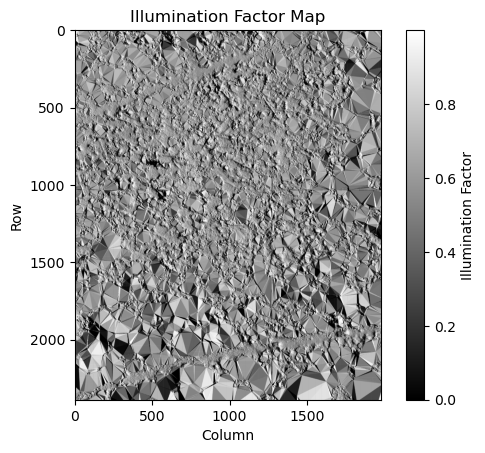

In [19]:
# Plot the illumination factor
plt.imshow(illumination, cmap='gray')
plt.colorbar(label='Illumination Factor')
plt.title('Illumination Factor Map')
plt.xlabel('Column')
plt.ylabel('Row')
plt.show()

### Function to perform topographic correction using SCS+C method

In [20]:
def scs_c_correction(reflectance, slope, sun_zenith, sun_azimuth, aspect):
    # Convert all input angles to radians
    slope_rad = np.radians(slope)
    sun_zenith_rad = np.radians(sun_zenith)
    sun_azimuth_rad = np.radians(sun_azimuth)
    aspect_rad = np.radians(aspect)

    relative_azimuth_rad = sun_azimuth_rad - aspect_rad

    # Compute the cosine of the incidence angle
    cos_i = np.cos(sun_zenith_rad) * np.cos(slope_rad) + np.sin(sun_zenith_rad) * np.sin(slope_rad) * np.cos(relative_azimuth_rad)
    cos_i = np.maximum(0, cos_i) 

    # Initialize arrays for corrected reflectance and C coefficients
    corrected_reflectance = np.empty(reflectance.shape)
    C = np.empty(reflectance.shape[0])  # Adjusted to fit the first dimension (number of bands)

    # Apply topographic correction to each band
    for i in range(reflectance.shape[0]):  # Adjusted to iterate over bands
        # Reshape the arrays
        cos_i_flat = cos_i.flatten()
        reflectance_flat = reflectance[i, :, :].flatten()  # Adjusted to select a specific band
        with warnings.catch_warnings():
            warnings.simplefilter('ignore', np.RankWarning)
            # Calculate linear regression parameters for the current band
            slope, intercept = np.polyfit(cos_i_flat, reflectance_flat, 1)

            # Calculate the C coefficient for the current band
            C[i] = intercept / slope

            # Apply topographic correction to the current band
            corrected_reflectance[i, :, :] = (reflectance[i, :, :] * (np.cos(sun_zenith_rad) * np.cos(slope_rad) + C[i])) / (cos_i + C[i])

    return corrected_reflectance, C, cos_i

In [21]:
corrected_reflectance, correction_factor, cos_i = scs_c_correction(reflectance, slope, sun_zenith, sun_azimuth,aspect)


In [22]:
corrected_reflectance

array([[[  866.30108643,  1037.82409668,  1329.82556152, ...,
          1247.06311035,  1623.67834473,  1474.34765625],
        [  856.63513184,   855.94830322,   697.65863037, ...,
          1708.24499512,  1348.15844727,  1285.38635254],
        [  907.63818359,   924.81219482,   745.96813965, ...,
          1391.02954102,  1525.15075684,  1181.79760742],
        ...,
        [ 2020.73535156,  1496.53344727,  1162.99438477, ...,
           509.60791016,   489.64245605,   444.46188354],
        [ 1482.2130127 ,  1387.8918457 ,  1935.48681641, ...,
           329.12307739,   486.95132446,   521.98516846],
        [ 1822.3269043 ,  1875.23413086,  1612.45446777, ...,
           303.49624634,   376.94223022,   609.19769287]],

       [[  987.82263184,  1460.9987793 ,  1699.08752441, ...,
          1580.0637207 ,  1674.96252441,  1811.1986084 ],
        [  889.94012451,   917.14355469,  1279.17175293, ...,
          1645.04760742,  1650.19958496,  1565.45910645],
        [ 1049.60205078, 

In [23]:
# print shapes to confirm operation
print("Corrected reflectance shape:", corrected_reflectance.shape)
# print("C shape:", C.shape)
print("cos_i shape:", cos_i.shape)

Corrected reflectance shape: (11, 2388, 1977)
cos_i shape: (2388, 1977)


In [24]:
def plot_reflectance(image, corrected_image, red_band=0, green_band=1, blue_band=2, percentiles=(5, 95)):
    # Plot original reflectance
    rgb_original = image[[red_band, green_band, blue_band], :, :].astype(float)
    bottom = np.percentile(rgb_original, percentiles[0], axis=(1, 2))
    top = np.percentile(rgb_original, percentiles[1], axis=(1, 2))
    rgb_original = np.clip(rgb_original, bottom[:, None, None], top[:, None, None])
    rgb_original = (rgb_original - np.min(rgb_original, axis=(1, 2), keepdims=True)) / (np.max(rgb_original, axis=(1, 2), keepdims=True) - np.min(rgb_original, axis=(1, 2), keepdims=True))

    # Plot corrected reflectance
    rgb_corrected = corrected_image[[red_band, green_band, blue_band], :, :].astype(float)
    bottom = np.percentile(rgb_corrected, percentiles[0], axis=(1, 2))
    top = np.percentile(rgb_corrected, percentiles[1], axis=(1, 2))
    rgb_corrected = np.clip(rgb_corrected, bottom[:, None, None], top[:, None, None])
    rgb_corrected = (rgb_corrected - np.min(rgb_corrected, axis=(1, 2), keepdims=True)) / (np.max(rgb_corrected, axis=(1, 2), keepdims=True) - np.min(rgb_corrected, axis=(1, 2), keepdims=True))

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot original reflectance
    axes[0].imshow(np.transpose(rgb_original, (1, 2, 0)))
    axes[0].set_title('Original Reflectance')
    axes[0].set_xlabel('Column')
    axes[0].set_ylabel('Row')

    # Plot corrected reflectance
    axes[1].imshow(np.transpose(rgb_corrected, (1, 2, 0)))
    axes[1].set_title('Corrected Reflectance using scs (solar angles)')
    axes[1].set_xlabel('Column')
    axes[1].set_ylabel('Row')

    plt.tight_layout()
    plt.show()
    plt.close()


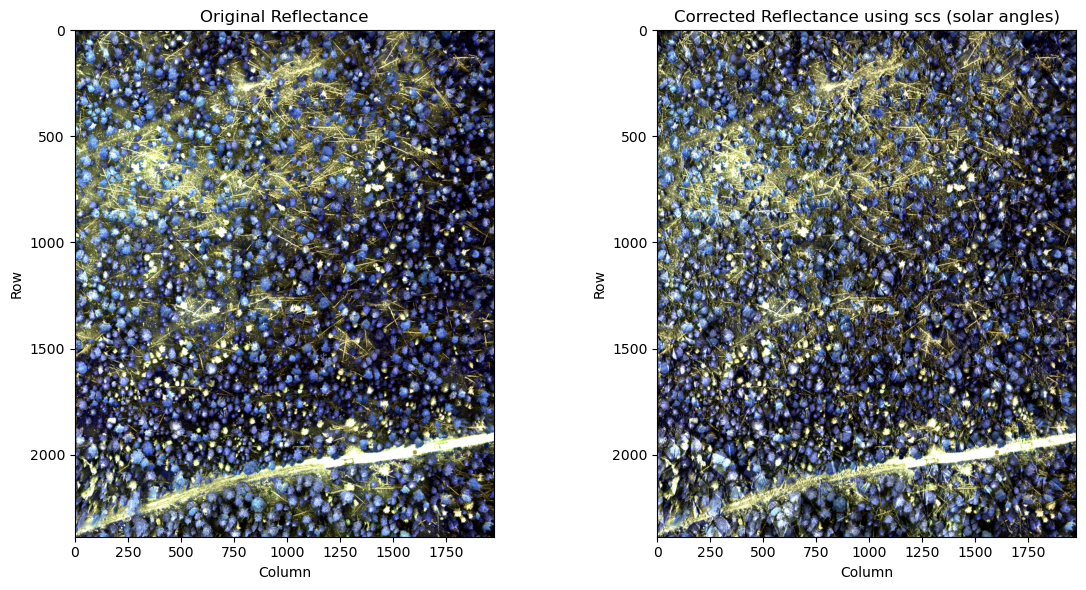

In [25]:
# Set the indices for the RGB bands
r_index = 0  # Red band index
g_index = 1  # Green band index
b_index = 2  # Blue band index

# Set the percentiles for contrast enhancement
percentiles = (5, 95)

# Call the plot_reflectance function
plot_reflectance(reflectance, corrected_reflectance, red_band=r_index, green_band=g_index, blue_band=b_index, percentiles=percentiles)


#### Plotting for NIR band

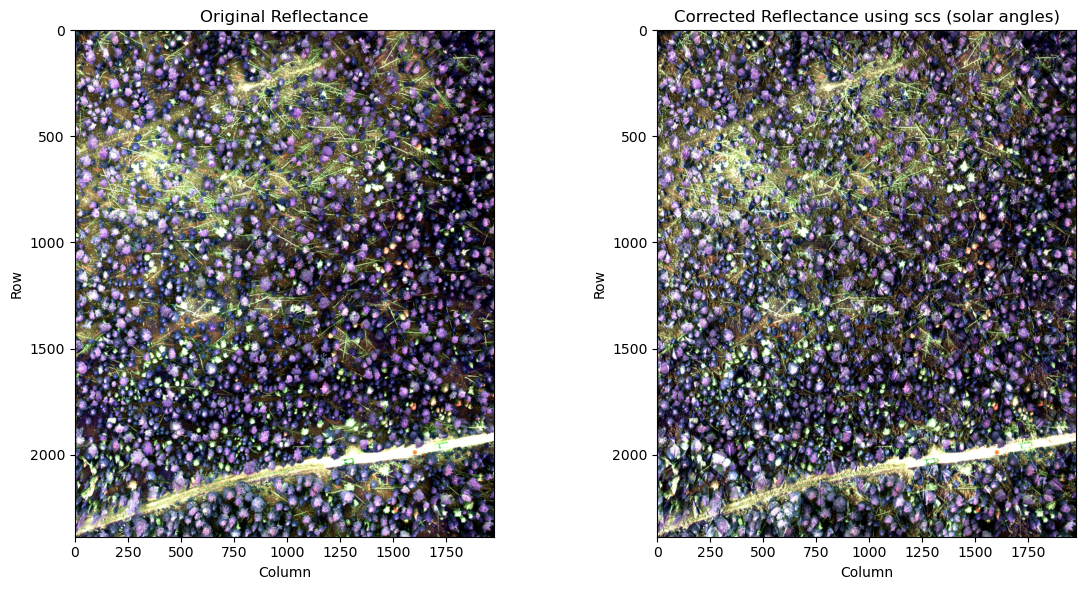

In [26]:
band_index = 4
plot_reflectance(reflectance, corrected_reflectance, band_index, percentiles=percentiles)

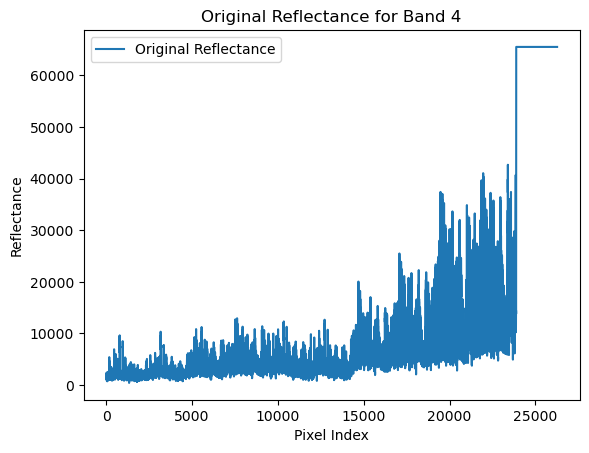

In [27]:

reflectance_band_4 = reflectance[:, :, 4].flatten()
fig, ax = plt.subplots()

# Plot the original reflectance values as a line plot
ax.plot(reflectance_band_4, label='Original Reflectance')

ax.set_xlabel('Pixel Index')
ax.set_ylabel('Reflectance')
ax.set_title('Original Reflectance for Band 4')

ax.legend()

plt.show()


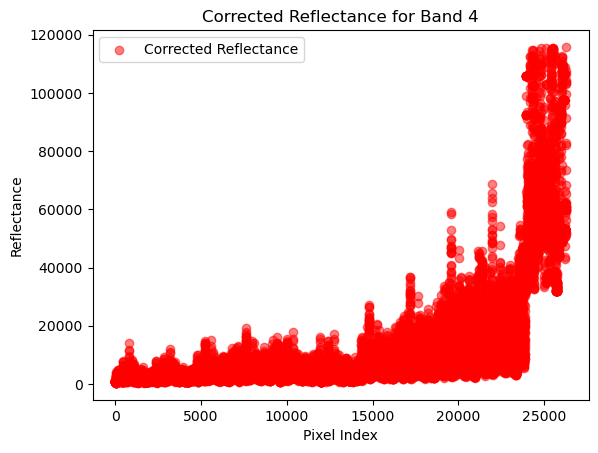

In [28]:
corrected_reflectance_band_4= corrected_reflectance[:, :, 4].flatten()

fig, ax = plt.subplots()

# Plot the corrected reflectance values as a scatter plot
ax.scatter(range(len(corrected_reflectance_band_4)), corrected_reflectance_band_4, label='Corrected Reflectance', color='red', alpha=0.5)

ax.set_xlabel('Pixel Index')
ax.set_ylabel('Reflectance')
ax.set_title('Corrected Reflectance for Band 4')

ax.legend()

plt.show()


In [29]:
print('before corretion',np.mean(reflectance))
print('after_correction',np.mean(corrected_reflectance))


before corretion 11171.42
after_correction 11019.70471273737


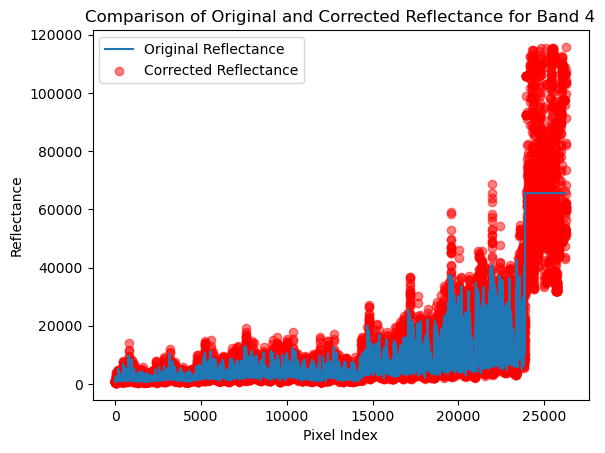

In [30]:

fig, ax = plt.subplots()

ax.plot(reflectance_band_4, label='Original Reflectance')

ax.scatter(range(len(corrected_reflectance_band_4)), corrected_reflectance_band_4, label='Corrected Reflectance', color='red', alpha=0.5)

ax.set_xlabel('Pixel Index')
ax.set_ylabel('Reflectance')
ax.set_title('Comparison of Original and Corrected Reflectance for Band 4')

ax.legend()
plt.show()


In [31]:
print('band_index is:', band_index)
print('Maximum valid band_index is:', reflectance.shape[0] - 1)
print('Shape of selected band of reflectance is:', reflectance[band_index].shape)

band_index is: 4
Maximum valid band_index is: 10
Shape of selected band of reflectance is: (2388, 1977)


In [32]:
def compare_reflectance(band_index, reflectance, corrected_reflectance, environmental_variable, variable_name):
    # Extract reflectance and corrected reflectance for the selected band
    reflectance_band = reflectance[band_index, :, :]
    corrected_reflectance_band = corrected_reflectance[band_index, :, :]

    # Flatten the inputs
    variable_flat = environmental_variable.flatten()
    reflectance_band_flat = reflectance_band.flatten()
    corrected_reflectance_band_flat = corrected_reflectance_band.flatten()

    # Create a new figure
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

    # Get the min and max for the X-axis (environmental variable)
    min_variable = np.min(variable_flat)
    max_variable = np.max(variable_flat)

    # Get the overall min and max for the Y-axis (reflectance)
    min_reflectance = np.min([np.min(reflectance_band_flat), np.min(corrected_reflectance_band_flat)])
    max_reflectance = np.max([np.max(reflectance_band_flat), np.max(corrected_reflectance_band_flat)])

    # Plot environmental variable vs. original reflectance values as a scatter plot
    ax[0].scatter(variable_flat, reflectance_band_flat, alpha=0.3)
    ax[0].set_xlabel(variable_name)
    ax[0].set_ylabel('Original Reflectance for Band ' + str(band_index))
    ax[0].set_title(variable_name + ' vs Original Reflectance')
    ax[0].set_xlim(min_variable, max_variable)
    ax[0].set_ylim(min_reflectance, max_reflectance)

    # Calculate linear regression for original reflectance
    m_orig, b_orig = np.polyfit(variable_flat, reflectance_band_flat, 1)
    ax[0].plot(variable_flat, m_orig*variable_flat + b_orig, color='black')
    ax[0].text(0.05, 0.95, f'y = {m_orig:.2f}x + {b_orig:.2f}', transform=ax[0].transAxes, fontsize=12,
            verticalalignment='top')

    # Plot environmental variable vs. corrected reflectance values as a scatter plot
    ax[1].scatter(variable_flat, corrected_reflectance_band_flat, alpha=0.3, color='red')
    ax[1].set_xlabel(variable_name)
    ax[1].set_ylabel('Corrected Reflectance for Band ' + str(band_index))
    ax[1].set_title(variable_name + ' vs Corrected Reflectance')
    ax[1].set_xlim(min_variable, max_variable)
    ax[1].set_ylim(min_reflectance, max_reflectance)

    # Calculate linear regression for corrected reflectance
    m_corr, b_corr = np.polyfit(variable_flat, corrected_reflectance_band_flat, 1)
    ax[1].plot(variable_flat, m_corr*variable_flat + b_corr, color='black')
    ax[1].text(0.05, 0.95, f'y = {m_corr:.2f}x + {b_corr:.2f}', transform=ax[1].transAxes, fontsize=12,
            verticalalignment='top')

    plt.tight_layout()
    plt.show()




The difference in the slopes between the original reflectance and corrected reflectance suggests that the correction has made the reflectance less sensitive to changes in illumination. 

C:\Users\JANUSHI SHASTRI\AppData\Local\Temp\ipykernel_19616\2058834725.py:31: RankWarning: Polyfit may be poorly conditioned
  m_orig, b_orig = np.polyfit(variable_flat, reflectance_band_flat, 1)
C:\Users\JANUSHI SHASTRI\AppData\Local\Temp\ipykernel_19616\2058834725.py:45: RankWarning: Polyfit may be poorly conditioned
  m_corr, b_corr = np.polyfit(variable_flat, corrected_reflectance_band_flat, 1)


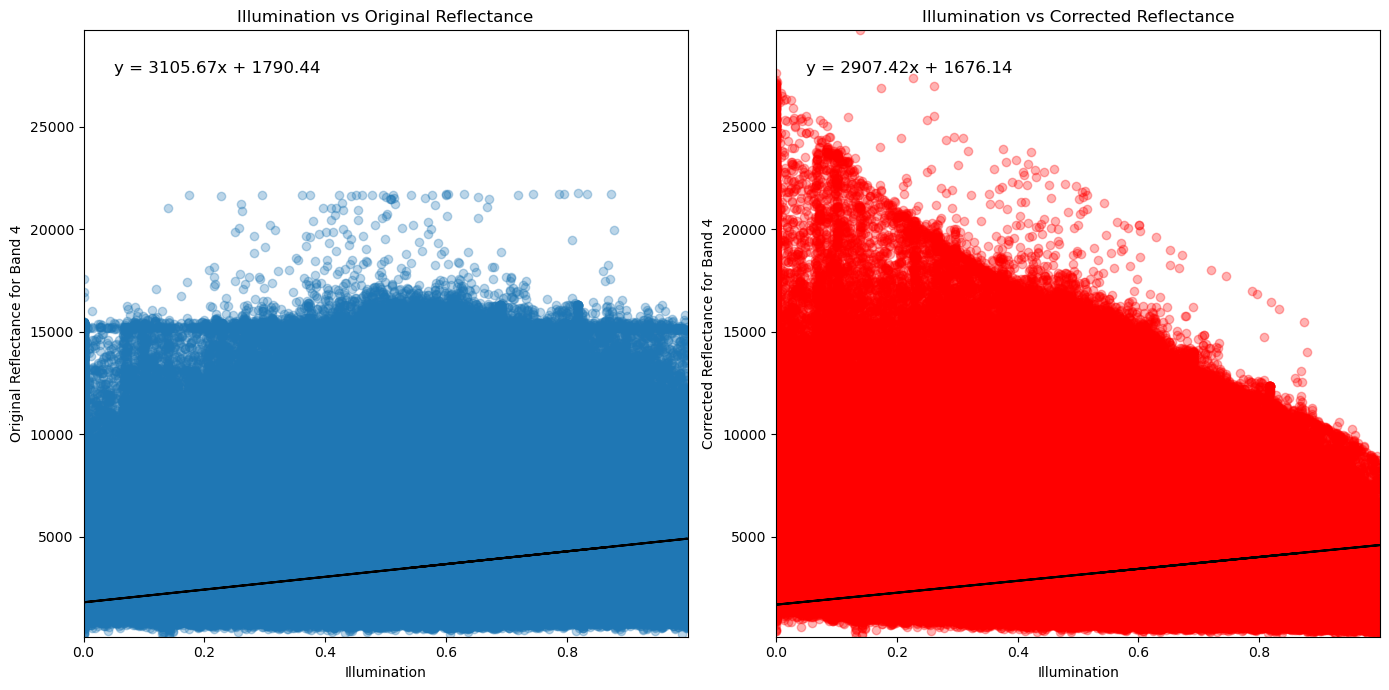

In [33]:
compare_reflectance(4, reflectance, corrected_reflectance, illumination, 'Illumination')


C:\Users\JANUSHI SHASTRI\AppData\Local\Temp\ipykernel_19616\2058834725.py:31: RankWarning: Polyfit may be poorly conditioned
  m_orig, b_orig = np.polyfit(variable_flat, reflectance_band_flat, 1)
C:\Users\JANUSHI SHASTRI\AppData\Local\Temp\ipykernel_19616\2058834725.py:45: RankWarning: Polyfit may be poorly conditioned
  m_corr, b_corr = np.polyfit(variable_flat, corrected_reflectance_band_flat, 1)


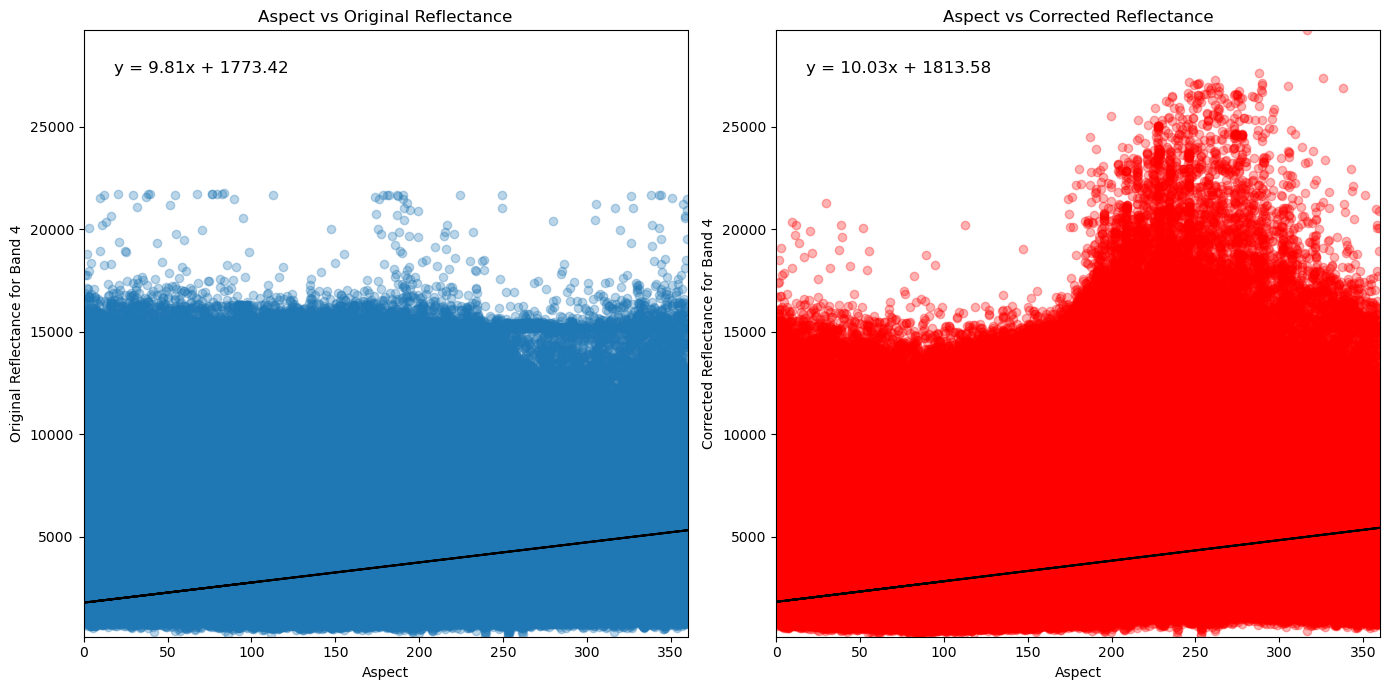

In [34]:
compare_reflectance(4, reflectance, corrected_reflectance, aspect, 'Aspect')

In [56]:
def compare_reflectance(band_index, reflectance, corrected_reflectance, environmental_variable, variable_name):
    # Extract reflectance and corrected reflectance for the selected band
    reflectance_band = reflectance[band_index, :, :]
    corrected_reflectance_band = corrected_reflectance[band_index, :, :]

    # Flatten the inputs
    variable_flat = environmental_variable.flatten()
    reflectance_band_flat = reflectance_band.flatten()
    corrected_reflectance_band_flat = corrected_reflectance_band.flatten()

    # Calculate linear regression for original reflectance
    m_orig, b_orig = np.polyfit(variable_flat, reflectance_band_flat, 1)

    # Calculate linear regression for corrected reflectance
    m_corr, b_corr = np.polyfit(variable_flat, corrected_reflectance_band_flat, 1)

    return m_orig, m_corr




In [57]:
#aspect
m_orig, m_corr = compare_reflectance(band_index, reflectance, corrected_reflectance, aspect, 'aspect')
print("Original reflectance slope: ", m_orig)
print("Corrected reflectance slope: ", m_corr)

C:\Users\JANUSHI SHASTRI\AppData\Local\Temp\ipykernel_19616\4008976700.py:12: RankWarning: Polyfit may be poorly conditioned
  m_orig, b_orig = np.polyfit(variable_flat, reflectance_band_flat, 1)


Original reflectance slope:  9.811575254001347
Corrected reflectance slope:  10.033782690960692


C:\Users\JANUSHI SHASTRI\AppData\Local\Temp\ipykernel_19616\4008976700.py:15: RankWarning: Polyfit may be poorly conditioned
  m_corr, b_corr = np.polyfit(variable_flat, corrected_reflectance_band_flat, 1)


In [58]:
#illumination
m_orig, m_corr = compare_reflectance(band_index, reflectance, corrected_reflectance, illumination, 'illumination')
print("Original reflectance slope: ", m_orig)
print("Corrected reflectance slope: ", m_corr)

C:\Users\JANUSHI SHASTRI\AppData\Local\Temp\ipykernel_19616\4008976700.py:12: RankWarning: Polyfit may be poorly conditioned
  m_orig, b_orig = np.polyfit(variable_flat, reflectance_band_flat, 1)
C:\Users\JANUSHI SHASTRI\AppData\Local\Temp\ipykernel_19616\4008976700.py:15: RankWarning: Polyfit may be poorly conditioned
  m_corr, b_corr = np.polyfit(variable_flat, corrected_reflectance_band_flat, 1)


Original reflectance slope:  3105.674784949644
Corrected reflectance slope:  2907.4151118825753


The fact that the slope for the corrected reflectance is slightly lower than the slope for the original reflectance suggests that the correction process has slightly decreased the sensitivity of the reflectance to changes in illumination. This could mean that the topographic correction has successfully mitigated some of the effects of varying illumination conditions on the reflectance measurements.

## NDVI calculation

### Function to do ndvi calcualtion

In [61]:
def calculate_ndvi(ref, red_band_index, nir_band_index):
    # Extract the specific bands from the reflectance data
    red_band = ref[red_band_index, :, :]
    nir_band = ref[nir_band_index, :, :]
    
    # Avoid divide by zero errors
    denominator = nir_band + red_band
    denominator[denominator == 0] = 0.0001
    
    # Calculate NDVI
    ndvi = (nir_band - red_band) / denominator
    
    return ndvi

In [62]:

red_band_index = 3
nir_band_index = 4


ndvi_corrected = calculate_ndvi(corrected_reflectance, red_band_index, nir_band_index)
# ndvi = np.where(ndvi > 0.5, ndvi, np.nan)
print(ndvi_corrected)
ndvi_threshold = 0.5
ndvi_count = np.sum(ndvi_corrected >= ndvi_threshold)
print("Number of pixels with NDVI >= 0.5: ", ndvi_count)

[[-0.24319937 -0.27022753 -0.37338112 ... -0.26542052 -0.24065594
  -0.2613467 ]
 [-0.25555976 -0.28241873 -0.35635099 ... -0.25209281 -0.2177677
  -0.32843259]
 [-0.38186407 -0.24218081 -0.28020647 ... -0.27590784 -0.31577663
  -0.30058628]
 ...
 [ 0.02643966 -0.10208201 -0.17839085 ... -0.11131899 -0.00962748
   0.        ]
 [-0.08460119 -0.072418   -0.07118914 ... -0.35828879 -0.12207528
  -0.10193974]
 [-0.09827789 -0.18343633 -0.11901245 ... -0.33442087 -0.60403728
  -0.16900677]]
Number of pixels with NDVI >= 0.5:  374


### only 374 pixels are >= 0.5 , therefore considering ndvi without threshold

### NDVI for reflectance

In [64]:
ndvi_reflectance = calculate_ndvi(reflectance, red_band_index, nir_band_index)
print(ndvi_reflectance)
ndvi_threshold = 0.5
ndvi_count = np.sum(ndvi_reflectance >= ndvi_threshold)
print("Number of pixels with NDVI >= 0.5: ", ndvi_count)

[[-0.24319935 -0.27022755 -0.3733811  ... -0.26542056 -0.24065593
  -0.2613467 ]
 [-0.25555974 -0.28241873 -0.35635096 ... -0.2520928  -0.21776766
  -0.3284326 ]
 [-0.3818641  -0.24218082 -0.28020647 ... -0.27590784 -0.31577665
  -0.3005863 ]
 ...
 [ 0.02643961 -0.10208202 -0.17839088 ... -0.11131899 -0.00962746
   0.        ]
 [-0.0846012  -0.07241798 -0.07118917 ... -0.35828876 -0.12207528
  -0.10193975]
 [-0.09827784 -0.18343633 -0.11901248 ... -0.3344209  -0.6040373
  -0.16900676]]
Number of pixels with NDVI >= 0.5:  374


In [65]:
import matplotlib.pyplot as plt

def plot_correlation_2(x, y1, y2, x_label, y1_label, y2_label, title):
    # Reshape arrays for plotting
    x_flat = x.flatten()
    y1_flat = y1.flatten()
    y2_flat = y2.flatten()

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Find the range of x and y for setting plot limits
    x_min, x_max = np.min(x_flat), np.max(x_flat)
    y_min = np.min([np.min(y1_flat), np.min(y2_flat)])
    y_max = np.max([np.max(y1_flat), np.max(y2_flat)])

    axs[0].scatter(x_flat, y1_flat, s=1, color="#0D52BD", alpha=0.5)
    m, b = np.polyfit(x_flat, y1_flat, 1)
    axs[0].plot(x_flat, m*x_flat + b, color='red', linewidth=2)
    axs[0].set_title(f'Correlation between {x_label} and {y1_label}')
    axs[0].set_xlabel(x_label)
    axs[0].set_ylabel(y1_label)
    axs[0].set_xlim([x_min, x_max])
    axs[0].set_ylim([y_min, y_max])
    axs[0].text(0.05, 0.95, f'Slope = {m:.2f}', transform=axs[0].transAxes, fontsize=12, verticalalignment='top')

    axs[1].scatter(x_flat, y2_flat, s=1, color="#0D52BD", alpha=0.5)
    m, b = np.polyfit(x_flat, y2_flat, 1)
    axs[1].plot(x_flat, m*x_flat + b, color='red', linewidth=2)
    axs[1].set_title(f'Correlation between {x_label} and {y2_label}')
    axs[1].set_xlabel(x_label)
    axs[1].set_ylabel(y2_label)
    axs[1].set_xlim([x_min, x_max])
    axs[1].set_ylim([y_min, y_max])
    axs[1].text(0.05, 0.95, f'Slope = {m:.2f}', transform=axs[1].transAxes, fontsize=12, verticalalignment='top')

    plt.tight_layout()
    plt.show()

C:\Users\JANUSHI SHASTRI\AppData\Local\Temp\ipykernel_19616\2960290062.py:17: RankWarning: Polyfit may be poorly conditioned
  m, b = np.polyfit(x_flat, y1_flat, 1)
C:\Users\JANUSHI SHASTRI\AppData\Local\Temp\ipykernel_19616\2960290062.py:27: RankWarning: Polyfit may be poorly conditioned
  m, b = np.polyfit(x_flat, y2_flat, 1)


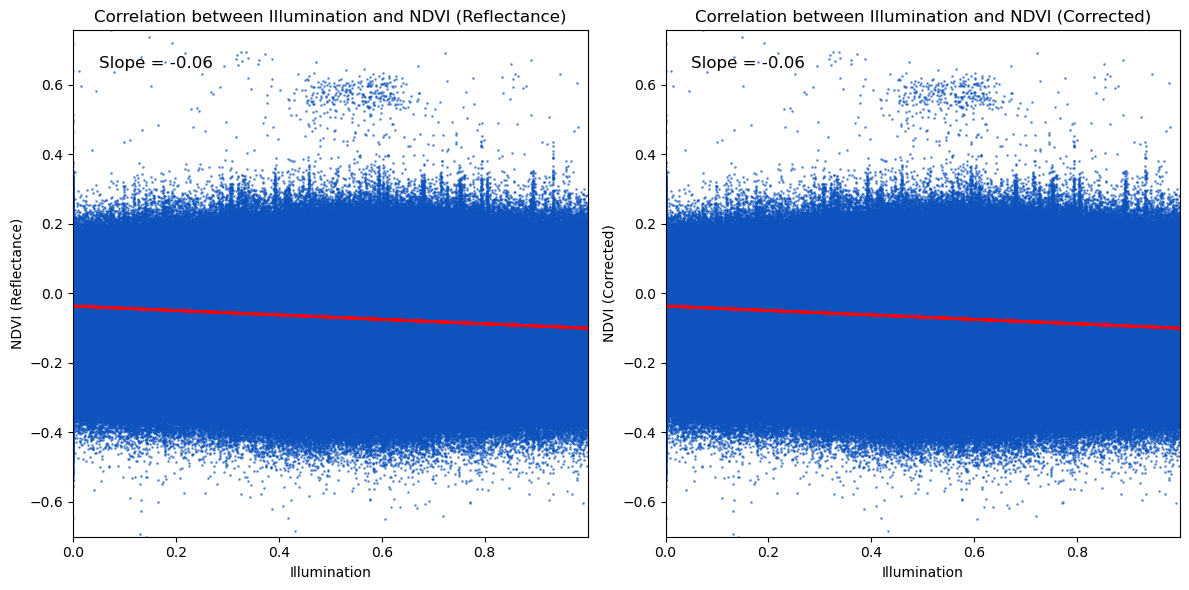

In [66]:
plot_correlation_2(illumination, ndvi_reflectance, ndvi_corrected, 'Illumination', 'NDVI (Reflectance)', 'NDVI (Corrected)', 'Illumination vs NDVI')


C:\Users\JANUSHI SHASTRI\AppData\Local\Temp\ipykernel_19616\2960290062.py:17: RankWarning: Polyfit may be poorly conditioned
  m, b = np.polyfit(x_flat, y1_flat, 1)
C:\Users\JANUSHI SHASTRI\AppData\Local\Temp\ipykernel_19616\2960290062.py:27: RankWarning: Polyfit may be poorly conditioned
  m, b = np.polyfit(x_flat, y2_flat, 1)


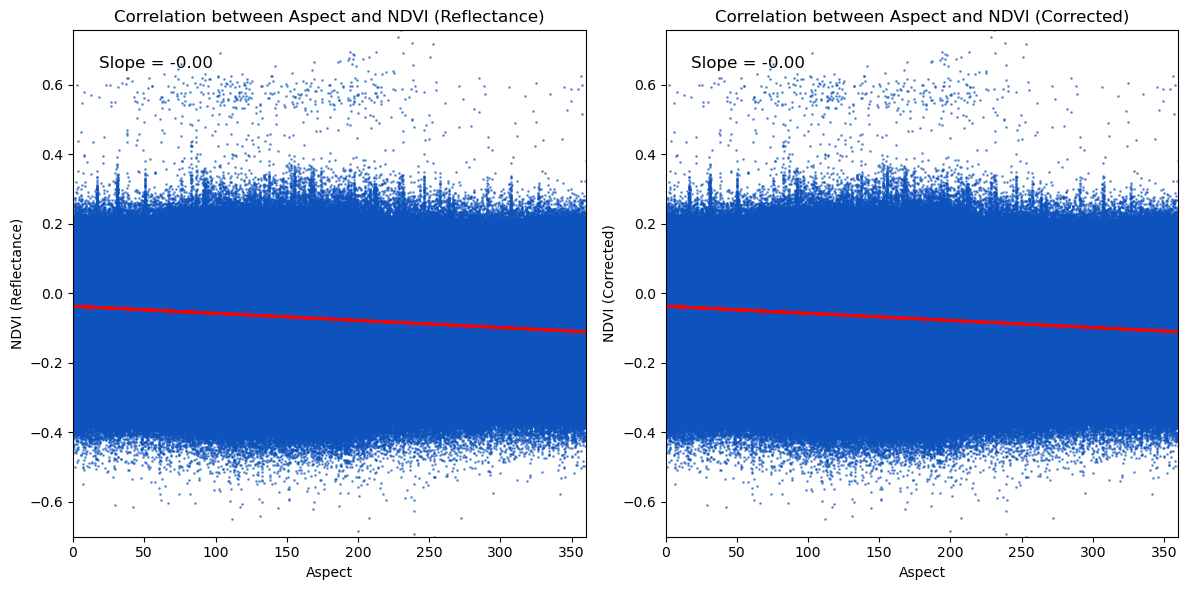

In [67]:
plot_correlation_2(aspect, ndvi_reflectance, ndvi_corrected, 'Aspect', 'NDVI (Reflectance)', 'NDVI (Corrected)', 'Aspect vs NDVI')
